# tensorflow 2系列03 断点续训，自动停止训练
本期文章是一个系列课程，本文是这个系列的第3篇复习笔记

(1)Build and train neural network models using TensorFlow 2.x  
(2)Image classification  
(3)Natural language processing(NLP)  
(4)Time series, sequences and predictions  

## 断点续训
断点续传主要是模型序列化，然后重新加载模型继续训练，这个对于实际生产应用非常有帮助，可以实现在线实时训练．而不用丢失之前的训练进度．
主要通过model.laod_weights函数来完成模型的加载，tensorflow的模型文件格式一般是ckpt文件
### 读取模型
```python
checkponit_save_path="./checkponit/fashion.ckpt"
if os.path.exists(checkponit_save_path+".index"):
    print("------------load the model -------------")
    model.load_weights(checkponit_save_path)
```
### 保存模型
```python
tf.keras.callbacks.ModelCheckpoint(
    filepath="路径文件名",
    save_weights_only=True/False,
    save_best_only=True/False
)
```
### 训练时调用
```python
cp_callback=tf.keras.callbacks.ModelCheckpoint(filepath=checkponit_save_path
    save_weights_only=True,
    save_best_only=True
)
history=model.fit(x,y,batch_size=32,epochs=5,validation_data=(x_test,y_test),validation_freq=1,callbacks=[cp_callback])
```

## 自动停止训练  
主要是实现一个callback的子类来获取实际中的参数来控制stop_training变量达到停止训练目的．
```python
class MyCallback(tf.keras.callbacks.Callback):
    
    def on_epoch_end(self,epoch,logs={}):
        if (logs.get("loss")<0.25):
            print("\n loss is low so cancel train")
            self.model.stop_training=True
```

## 代码实战

2.3.0
------------load the model -------------
Epoch 1/50
1853/1875 [============================>.] - ETA: 0s - loss: 0.2806 - accuracy: 0.8959
 loss is low so cancel train
313/313 [==============================] - 0s 1ms/step - loss: 0.3418 - accuracy: 0.8796
9


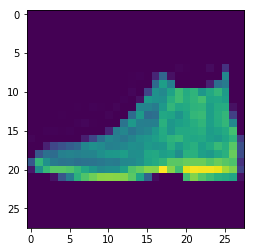

In [16]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)
(train_x,train_y),(test_x,test_y)=tf.keras.datasets.fashion_mnist.load_data()

model=tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=(28,28)))
model.add(tf.keras.layers.Dense(128,activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(10,activation=tf.nn.softmax))
model.compile(optimizer="adam",loss=tf.keras.losses.sparse_categorical_crossentropy,metrics=["accuracy"])

checkponit_save_path="/tmp/checkponit/fashion.ckpt"         
if os.path.exists(checkponit_save_path+".index"):
    print("------------load the model -------------")
    model.load_weights(checkponit_save_path)

class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs={}):
        if logs.get("loss")<0.3:
            print("\n loss is low so cancel train")
            self.model.stop_training=True

model_save_callback=tf.keras.callbacks.ModelCheckpoint(filepath=checkponit_save_path,
    monitor = 'val_loss',
    save_weights_only=True,
    save_best_only=True
)

auto_stop_callback=MyCallback()

history=model.fit(train_x/255,train_y,batch_size=32,epochs=50,
validation_data=(test_x,test_y),validation_freq=1,
callbacks=[auto_stop_callback,model_save_callback])
model.evaluate(test_x/255,test_y)
t=np.array(test_x[0]/255).reshape(1,28,28)
print(np.argmax(model.predict(t)))
plt.imshow(test_x[0])

## 总结

通过实现不同的callback，可以对模型训练期间进行精确控制．
包括模型的断点续训和自动停止训练
